# Exercise 6 | Robust MPC



## Problem 1 | Robust Invariant Set

Design a robust MPC controller for the following linear system:

$$x^+ = Ax + Bu + w,  A=\begin{bmatrix}1 & 1 \\ 0 & 1\end{bmatrix}, B=\begin{bmatrix}1 \\ 0.5\end{bmatrix} $$

with constraints and bounded disturbance

$$\mathcal{X} = \{x \mid \|x\|_{\infty} \leq 3 \}, \quad \mathcal{U} = \{u \mid ~\|u\|_{\infty} \leq 0.5 \} \quad \mathcal{W} = \{w \mid \|w\|_{\infty} \leq 0.1 \} $$

The matrix $K$ is the LQR gain with $Q=I$ and $R=10$.



In [33]:
import numpy as np
from mpt4py import Polyhedron
from control import dlqr

A = np.array([[1, 1], [0, 1]])
B = np.array([[1], [0.5]])
Q = np.eye(2)
R = 10 * np.eye(1)

K, Qf, _ = dlqr(A, B, Q, R)
K = -K
A_cl = A + B @ K

x_max = 3.
u_max = 0.5
w_max = 0.1

X = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=x_max*np.ones(4))
U = Polyhedron.from_Hrep(A=np.vstack((np.eye(1), -np.eye(1))), b=u_max*np.ones(2))
W = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=w_max*np.ones(4))

### Task 1
Implement a function to compute the robust pre-set operator $\text{pre}^{\mathcal{W}}(\cdot)$


In [34]:
def robust_pre_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron) -> Polyhedron:
	"""
	Compute the robust pre-set of the polytopic set Omega under the 
	autonomous LTI system x^+ = A_cl * x and polytopic disturbance set W.
	"""
	# TODO: ------------------
	# TODO: add your code here
	F = Omega.A
	f = Omega.b
	n_ineq = f.shape[0]
	supp_W = np.zeros((n_ineq,))
	for i in range(n_ineq) :
		supp_W[i] = W.support(F[i, :])
	pre_Omega = Polyhedron.from_Hrep(F @ A_cl, f - supp_W)  
	# TODO: ------------------
	return pre_Omega

### Task 2
Implement a function to compute the maximal robust invariant set $\mathcal{X}_f^{\mathcal{W}}$ for the above system. Use it to compute the maximal robust invariant set for the system mentioned above.

Also compute the nominal maximal invariant set $\mathcal{X}_f$ using your code from previous exercises. 

Which set do you expect to be larger? Plot both sets and compare.

**Hints**: The algorithm to compute maximal robust invariant set is summarized in the following steps. This is indeed the same algorithm as computing maximal invariant set for nominal MPC. The only difference is the pre-set operator $\text{pre}(\Omega_i)$ is replaced by the robust pre set operator $\text{pre}^\mathcal{W}(\Omega_i)$. 

$$
\begin{array}{l}
	\Omega_0 \gets \mathcal{X} \\
	\textbf{loop} \\
	\quad \Omega_{i+1} \gets \text{pre}^\mathcal{W}(\Omega_i) \cap \Omega_i \\
	\quad \textbf{if} ~ \Omega_{i+1} == \textbf{pre}^\mathcal{W} (\Omega_i) \\
	\quad\quad \textbf{return} ~ \Omega_{\infty}^\mathcal{W} = \Omega_{i} \\
	\quad \textbf{end if} \\
	\textbf{end loop}
\end{array}
$$


In [39]:
def max_robust_invariant_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron, max_iter: int = 50) -> Polyhedron:
	"""
	Compute the maximal robust positive invariant set of the polytopic set Omega
	under the autonomous LTI system x^+ = A_cl * x.
	"""
	# TODO: ------------------
	# TODO: add your code here
	i = 0
	while i < max_iter :
		pre_Omega = robust_pre_set(A_cl, Omega, W)
		P, p = pre_Omega.A, pre_Omega.b
		F, f = Omega.A, Omega.b
		mat_intersect = np.block([[P], [F]]) # or use .intersect
		bound_intersect = np.block([[p], [f]]).flatten()
		new_Omega = Polyhedron.from_Hrep(mat_intersect, bound_intersect)
		if Omega == new_Omega :
			Omega = new_Omega
			print("Maximum robust positive invariant set found after {0} iterations !\n" .format(i+1))
			break
		print("Not yet convgerged at iteration {0}" .format(i+1))
		Omega = new_Omega
		i += 1
	return Omega
	# TODO: ------------------
	

In [40]:
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	# TODO: ------------------
	# TODO: add your code here
	i = 0
	while i < max_iter :
		F, f = X.A, X.b
		pre_X = Polyhedron.from_Hrep(F @ A_cl, f)
		mat_intersect = np.concatenate((pre_X.A, F), axis = 0) # or use .intersect
		bound_intersect = np.concatenate((f, f), axis = 0)
		X_new = Polyhedron.from_Hrep(mat_intersect, bound_intersect)
		if X == X_new :
			X = X_new
			print("Maximum positive invariant set found after {0} iterations !\n" .format(i+1))
			break
		print("Not yet convgerged at iteration {0}" .format(i+1))
		X = X_new
		i += 1
	return X
	# TODO: ------------------


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Maximum positive invariant set found after 3 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Maximum robust positive invariant set found after 5 iterations !



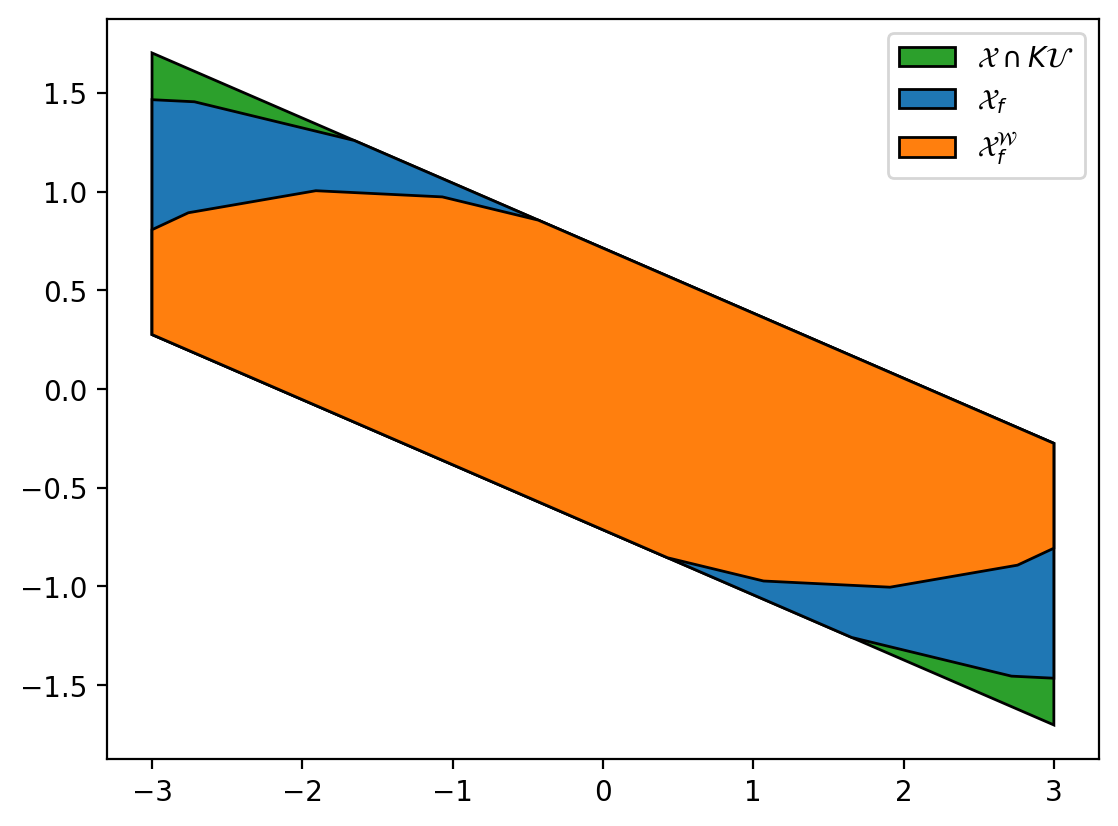

In [76]:
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A@K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)
Xf_W = max_robust_invariant_set(A_cl, X_and_KU, W)


# Plot the sets
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:orange', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
plt.legend()
plt.show()

### Task 3

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0\in\mathcal{X}_f^{\mathcal{W}} $. Show that the entire trajectory $\{x_i\}$ remains within $\mathcal{X}_f^{\mathcal{W}}$.

**Hints:** in *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.

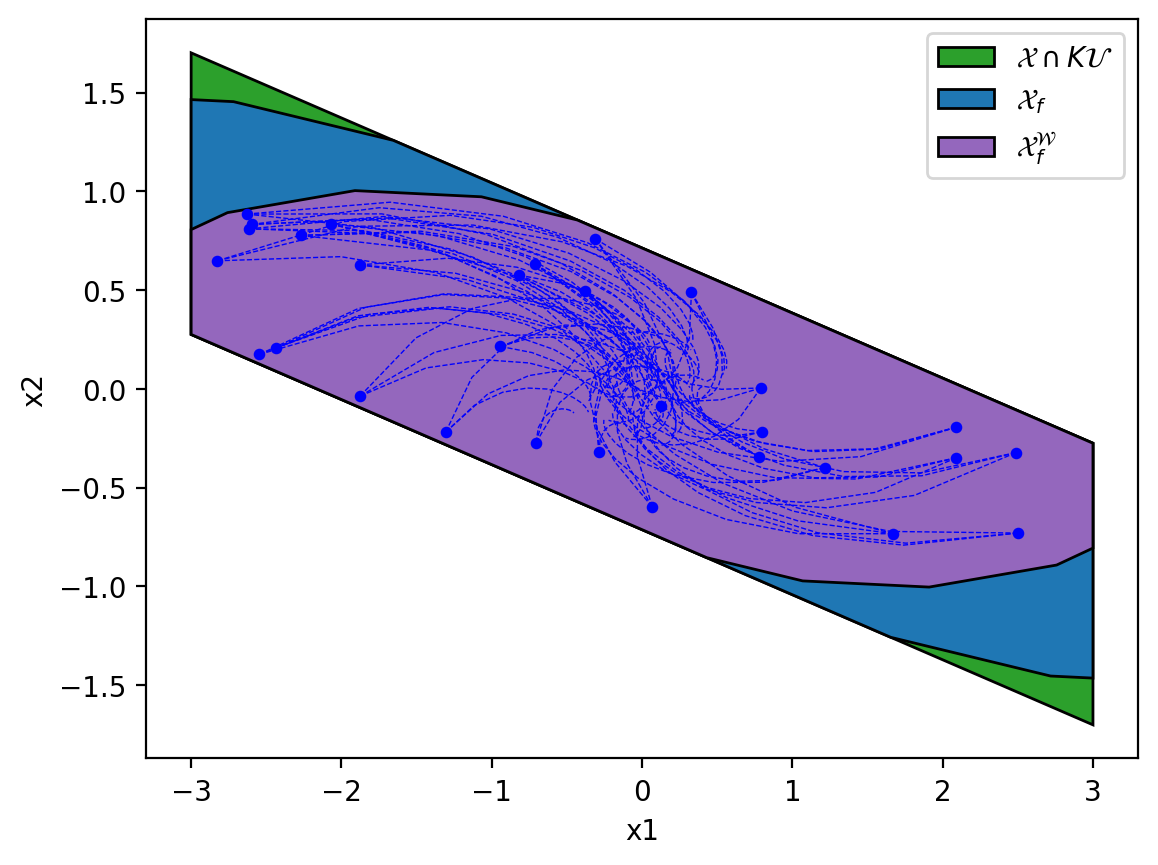

In [62]:
num_samples = 30
x0_samples = Xf_W.sample(num_samples)  # ndarray with shape (num_samples, 2)
N_sim = 10  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# TODO: ------------------
# TODO: add your code here
num_w_samples = 3
for i in range(num_samples):
    x0 = x0_samples[i, :]
    w_samples = W.sample(num_w_samples) # ndarray with shape (num_w_samples, 2)
    for j in range(num_w_samples) :
        w = w_samples[j, :]
        x_traj = np.zeros((x0.shape[0], N_sim+1))
        x_traj[:, 0] = x0
        for k in range(N_sim):
            x_traj[:, k+1] = A_cl @ x_traj[:, k] + w   
        ax.plot(x_traj[0, :], x_traj[1, :], color='blue', linestyle='--', linewidth=0.5)

ax.scatter(x0_samples[:, 0], x0_samples[:, 1], c='blue', s=10.)

# Sample disturbed trajectories and plot
# TODO: ------------------

plt.legend()
plt.show()

### Task 4

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0 \in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$. Show that there exists an $x_i \notin \mathcal{X}$.

**Hints:** You can sample points $x_0\in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$ by sampling a number of points from $\mathcal{X}_f$ and remove those that are in the $\mathcal{X}_f^{\mathcal{W}}$.

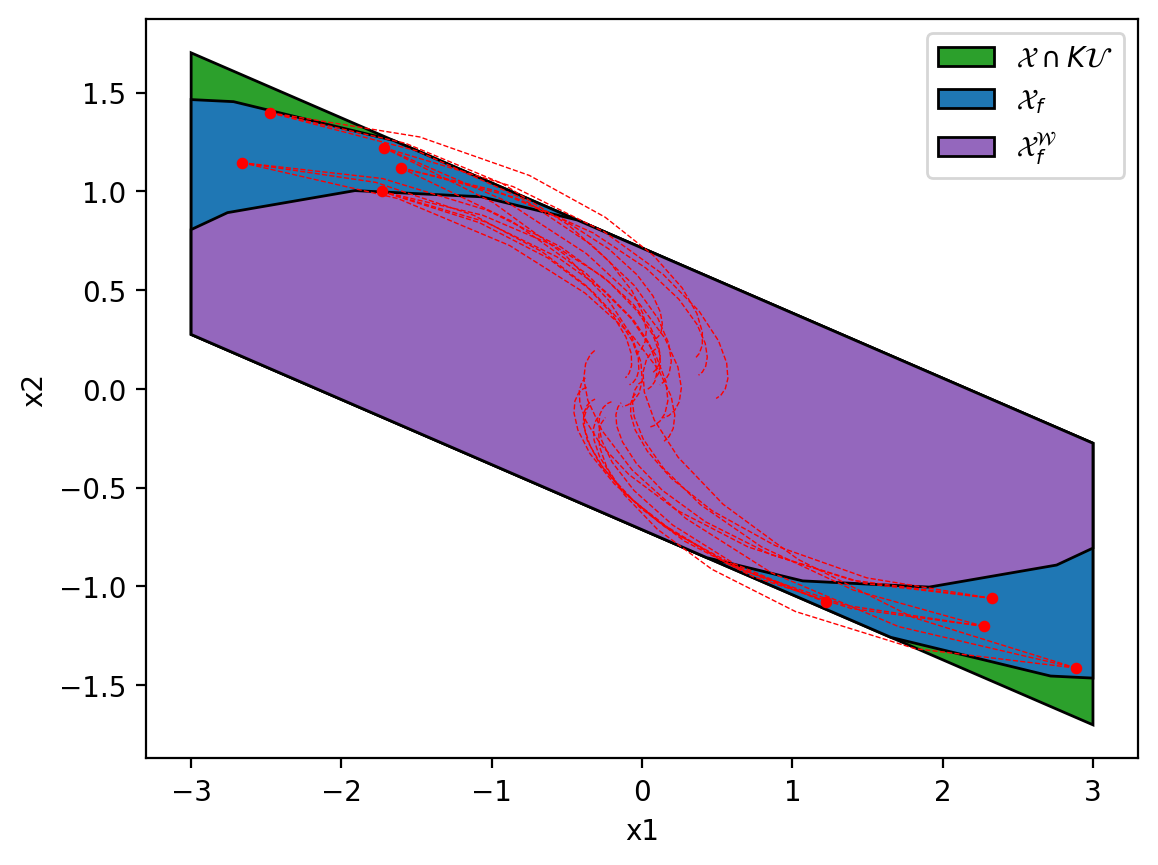

In [75]:
num_samples = 50
N_sim = 10  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# TODO: ------------------
# TODO: add your code here
# Sample disturbed trajectories and plot
x0_samples_init = Xf.sample(num_samples)
x0_samples = []
for x0_sample in x0_samples_init:
    if x0_sample not in Xf_W:
        x0_samples.append(x0_sample)
x0_samples = np.vstack(x0_samples)

num_x0_samples = x0_samples.shape[0]
num_w_samples = 3
for i in range(num_x0_samples):
    x0 = x0_samples[i, :]
    w_samples = W.sample(num_w_samples) # ndarray with shape (num_w_samples, 2)
    for j in range(num_w_samples) :
        w = w_samples[j, :]
        x_traj = np.zeros((x0.shape[0], N_sim+1))
        x_traj[:, 0] = x0
        for k in range(N_sim):
            x_traj[:, k+1] = A_cl @ x_traj[:, k] + w   
        ax.plot(x_traj[0, :], x_traj[1, :], color='red', linestyle='--', linewidth=0.5)

ax.scatter(x0_samples[:, 0], x0_samples[:, 1], c='red', s=10.)
# TODO: ------------------

plt.legend()
plt.show()